# Splitter tutorial

This notebook presents the possibilities of splitters. They will help to split the train and test data.
RePlay offers several classes:

* TimeSplitter
* RandomSplitter
* NewUsersSplitter
* ColdUserRandomSplitter
* TwoStageSplitter

Each of them provides its own capabilities for data split.

### Split data

To split the data, you must call the `.split()` method on the Splitter object

### Return

Splitters return `train` and `test` cached DataFrame to compute them once and re-use for models training, inference and metrics calculation.


In [ ]:
!pip install seaborn matplotlib

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from replay.preprocessing import LabelEncoder, LabelEncodingRule
from replay.utils.common import load_from_replay, save_to_replay

sns.set_theme(style="whitegrid", palette="muted")

## Get started

Download the dataset **MovieLens** and preprocess it with `LabelEncoder`.

`LabelEncoder` is similar to `DatasetLabelEncoder` except that `LabelEncoder` processes Pandas, Polars or Spark datasets when `DatasetLabelEncoder` processes `replay.data.Dataset`. 

In [ ]:
ratings = pd.read_csv(
    "./data/ml1m_ratings.dat", sep="\t", names=["user_id", "item_id", "rating", "timestamp"], engine="python"
)
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit="s")

In [4]:
ratings.head(5)

,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [ ]:
encoder = LabelEncoder(
    [
        LabelEncodingRule("user_id"),
        LabelEncodingRule("item_id"),
    ]
)
ratings = encoder.fit_transform(ratings)

`LabelEncoder` can be saved in JSON fortam with `save_to_replay()` or `.save()` methods. Than it can be loaded with `load_from_replay()` or `.load()` methods.

In [ ]:
save_to_replay(encoder, "./")  # or encoder.save("./")
loaded_encoder = load_from_replay("./")  # or LabelEncoder.load("./")

For examples, we will use the 20 users with biggest interactions history

In [6]:
top_users = ratings.groupby("user_id")[["item_id"]].count().nlargest(n=20, columns=["item_id"]).index

In [7]:
log_limit_20 = ratings[ratings.user_id.isin(top_users)]

In [8]:
len(log_limit_20)

28229

Function for viewing `train`, `test` data

In [9]:
def show_train_test(train, test):
    plt.figure(figsize=(25, 12))
    train_plt = train
    train_plt["split"] = "train"
    test_plt = test
    test_plt["split"] = "test"
    pd_for_print = pd.concat((train_plt, test_plt), axis=0)
    pd_for_print["user_id"] = pd_for_print["user_id"].astype(str)
    sns.scatterplot(data=pd_for_print, x="timestamp", y="user_id", hue="split", s=8 * 8)
    plt.autoscale(enable=True, axis="x")
    plt.grid(False)
    plt.show()

Function for printing stats of df

In [10]:
def get_df_info(df: pd.DataFrame):
    print(f"Total rows {len(df)}, unique users: {df.user_id.nunique()}, unique items: {df.item_id.nunique()}")

## General parameters of splitters

All splitters has the following common parameters:
* `drop_cold_users` flag to drop cold (not presented in train part) users from test

* `drop_cold_items` flag to drop cold (not presented in train part) users from test

* `date_column` timestamp column name

* `query_column` query id column name

* `item_column` item id column name

## class TimeSplitter()

Split into train and test by date.

#### Parameters other than gneral

* `test_start` string "yyyy-mm-dd" , int unix timestamp, datetime or a fraction for test size to determine the date automatically


In this example `test_start` parameter will take fraction for test size

In [11]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold=0.05,
    drop_cold_users=True,
    drop_cold_items=True,
    query_column="user_id",
)

In [12]:
train, test = date_splitter.split(log_limit_20)

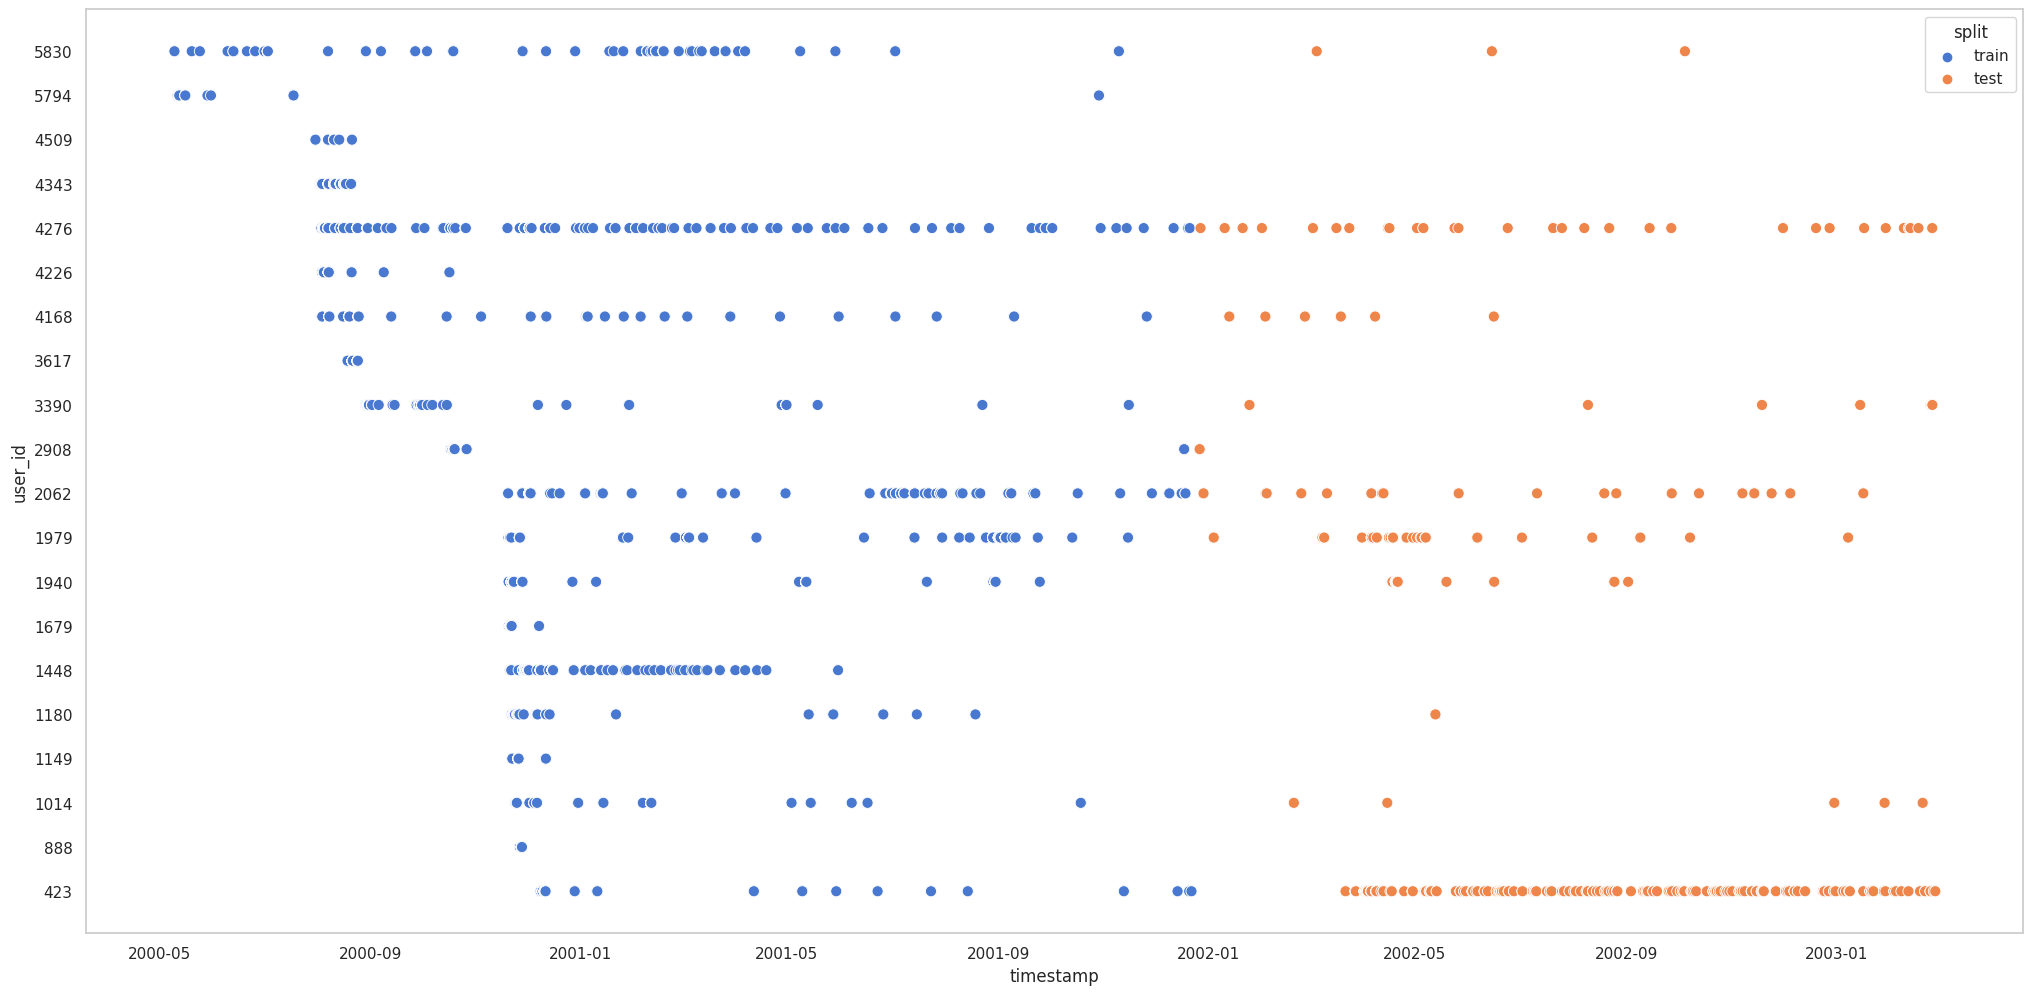

In [13]:
show_train_test(train, test)

In [14]:
get_df_info(train)

Total rows 26816, unique users: 20, unique items: 3303


In [15]:
get_df_info(test)

Total rows 1387, unique users: 11, unique items: 1152


In this example `test_start` parameter will take string "yyyy-mm-dd"

In [16]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold="2001-09",
    drop_cold_users=True,
    drop_cold_items=True,
    time_column_format="%Y-%m",
    query_column="user_id",
)

In [17]:
train, test = date_splitter.split(log_limit_20)

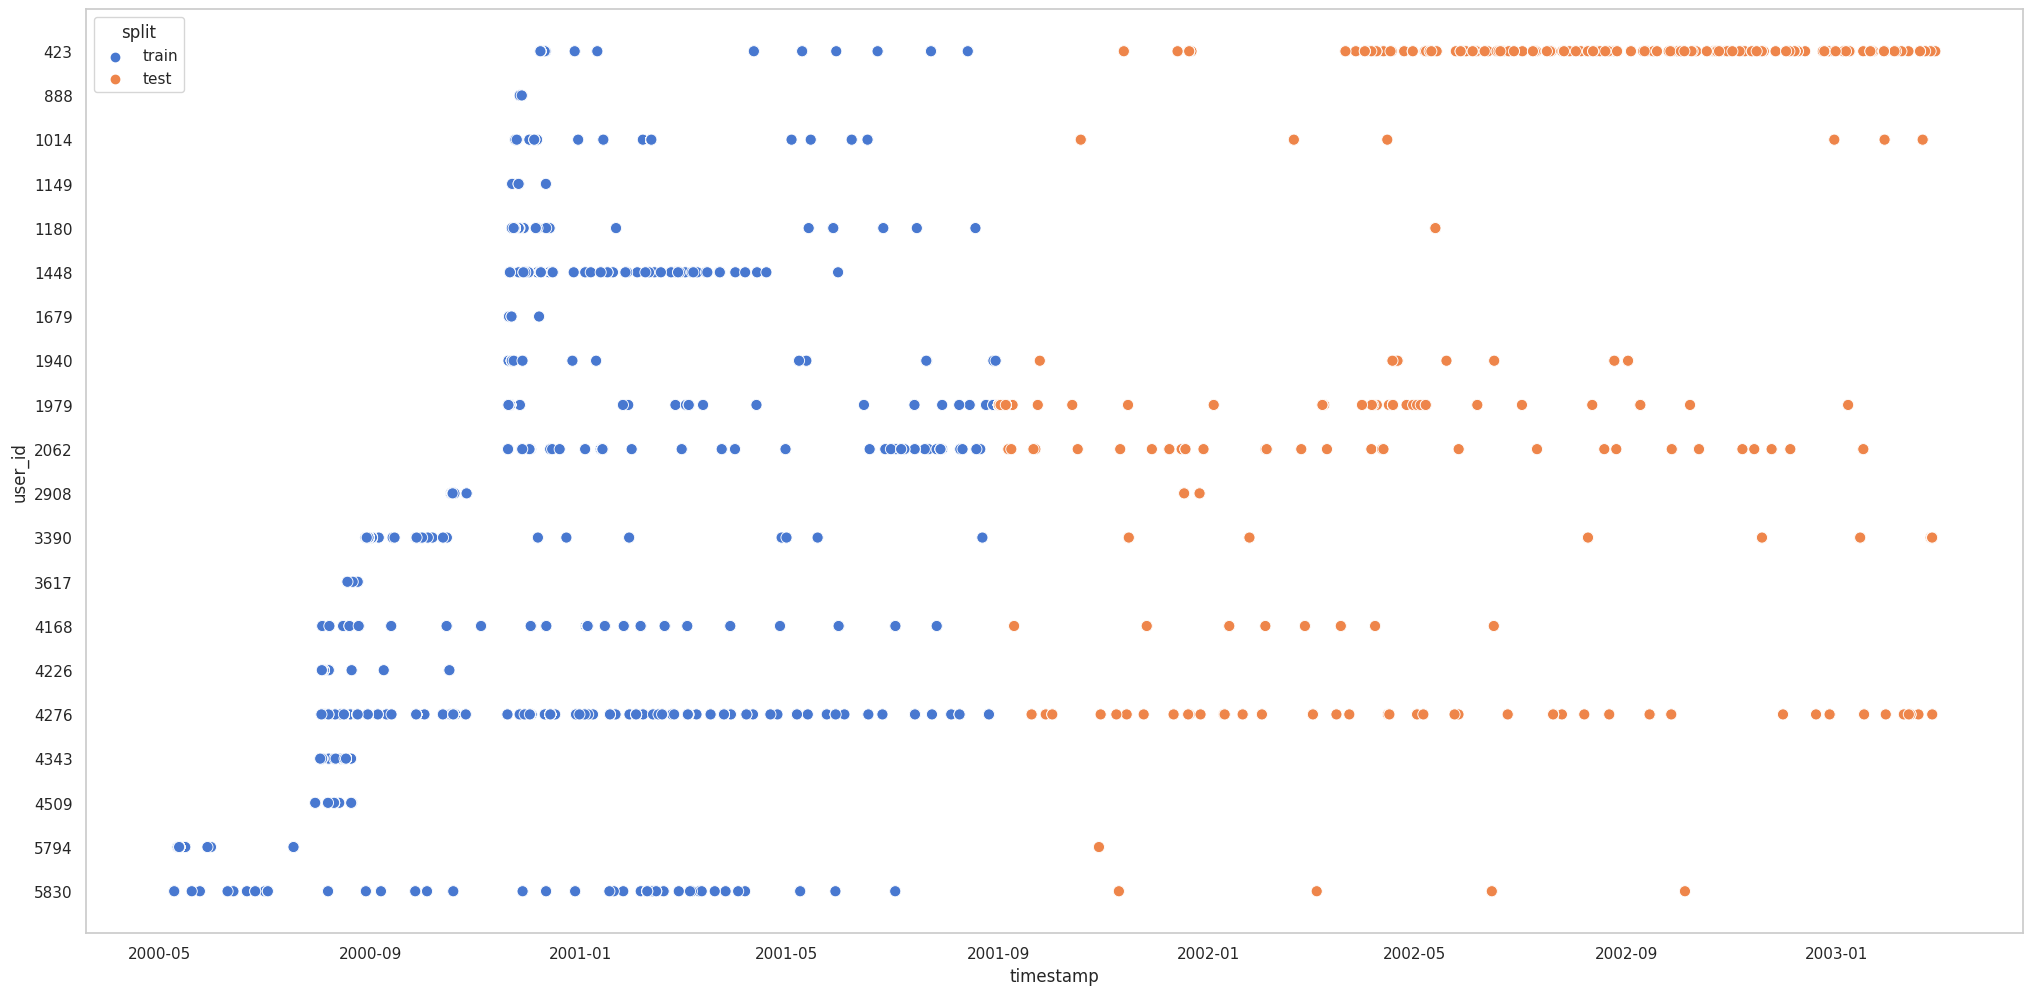

In [18]:
show_train_test(train, test)

In [19]:
get_df_info(train)

Total rows 26345, unique users: 20, unique items: 3281


In [20]:
get_df_info(test)

Total rows 1834, unique users: 12, unique items: 1399


### Learn more about the parameters `drop_cold_users`, `drop_cold_items`, `drop_zero_rel_in_test`

#### All parameters is false

In [21]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=False,
    drop_cold_items=False,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()`

In [22]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 300065, unique users: 2283, unique items: 3572


#### `drop_cold_users` is True 

In [23]:
date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=True,
    drop_cold_items=False,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_cold_users=True`. Compared to the disabled flag, the number of users has decreased.

In [24]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 111169, unique users: 1113, unique items: 3459


#### `drop_cold_items` is True 

In [25]:
date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=False,
    drop_cold_items=True,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_cold_items=True`. Compared to the disabled flag, the number of items has decreased.

In [26]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 299894, unique users: 2283, unique items: 3499


## class RandomSplitter()

Assign records into train and test at random.

#### Parameters other than general

* `test_size` float 

* `seed` random seed

In [27]:
from replay.splitters import RandomSplitter

random_splitter = RandomSplitter(
    test_size=0.4,
    drop_cold_users=True,
    drop_cold_items=True,
    query_column="user_id",
)

In [28]:
train, test = random_splitter.split(log_limit_20)

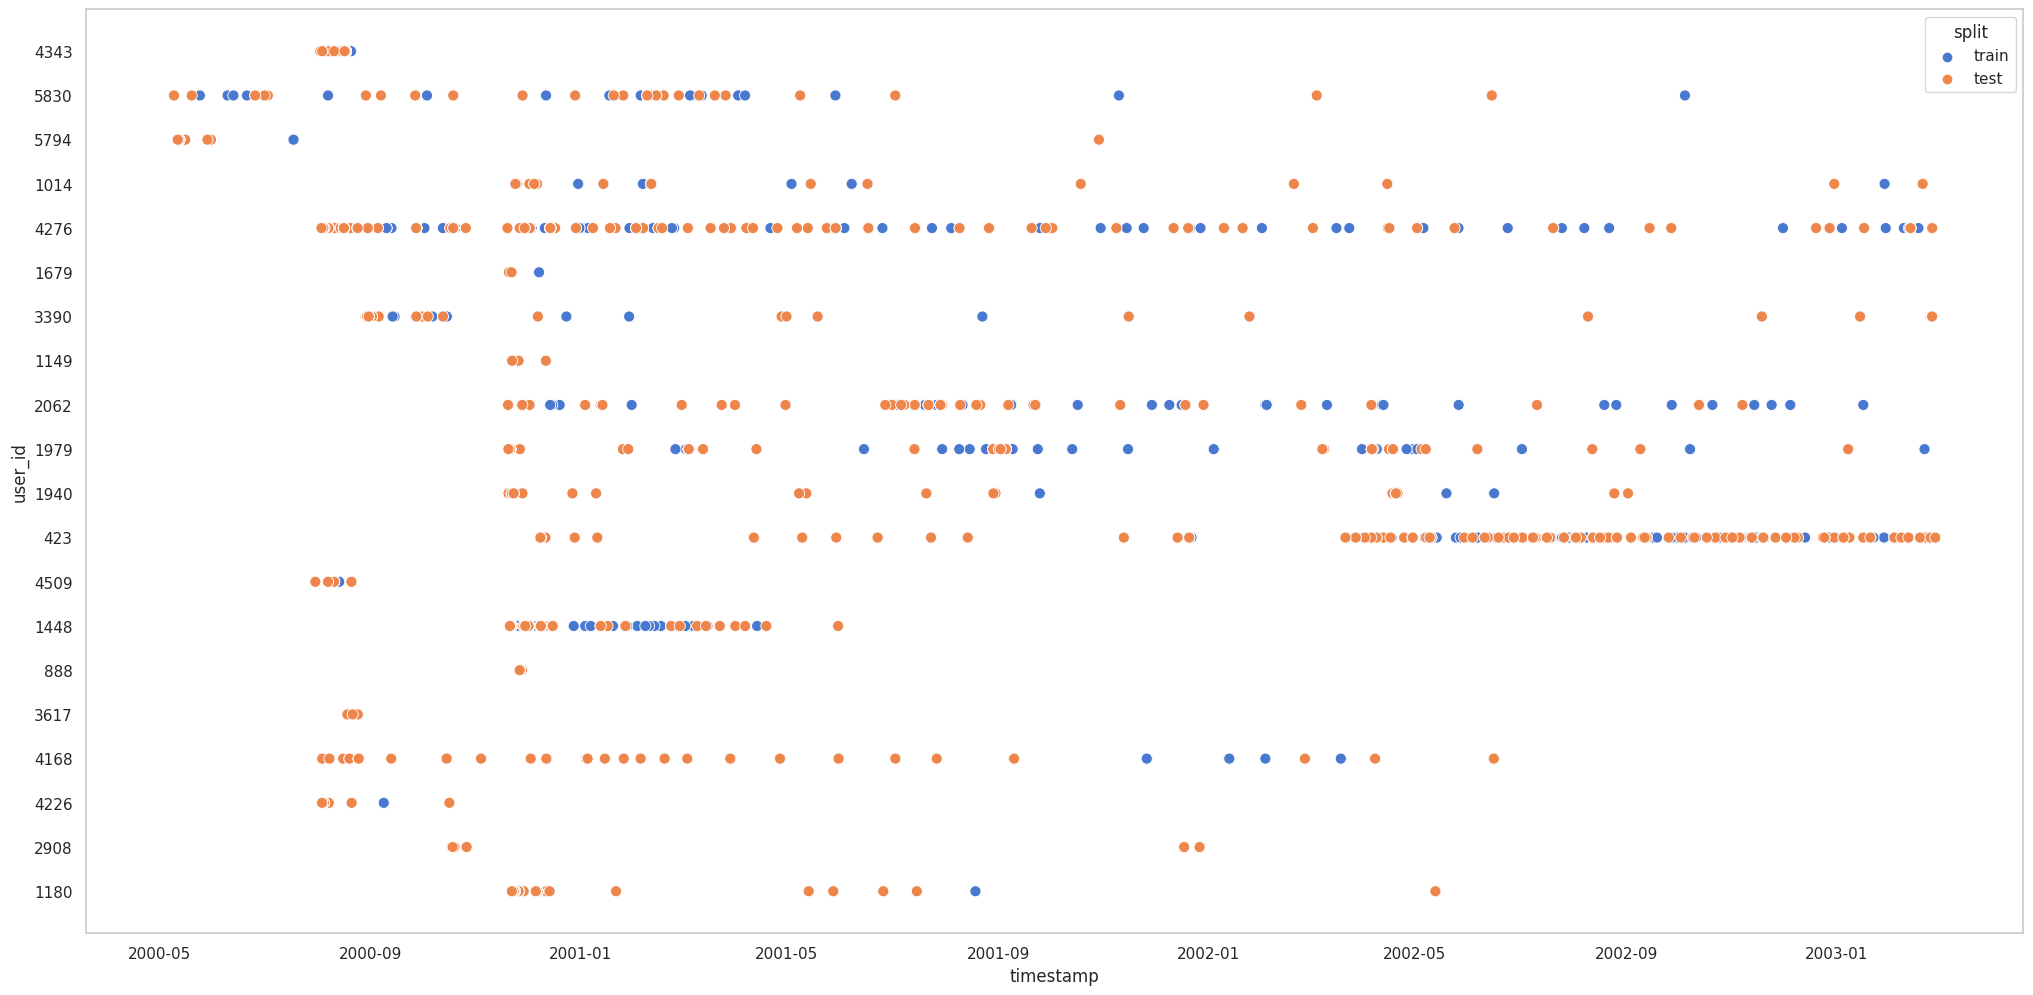

In [29]:
show_train_test(train, test)

In [30]:
get_df_info(train)

Total rows 16937, unique users: 20, unique items: 3146


In [31]:
get_df_info(test)

Total rows 11012, unique users: 20, unique items: 2757


## class NewUsersSplitter()

Only new users will be assigned to test set.
Splits log by timestamp so that test has `test_size` fraction of most recent users.

#### Parameters other than general

* `test_size` float 

In [32]:
from replay.splitters import NewUsersSplitter

new_user_splitter = NewUsersSplitter(
    test_size=0.3,
    query_column="user_id",
)

In [33]:
train, test = new_user_splitter.split(log_limit_20)

/tmp/ipykernel_7137/2154144320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_plt["split"] = 'train'


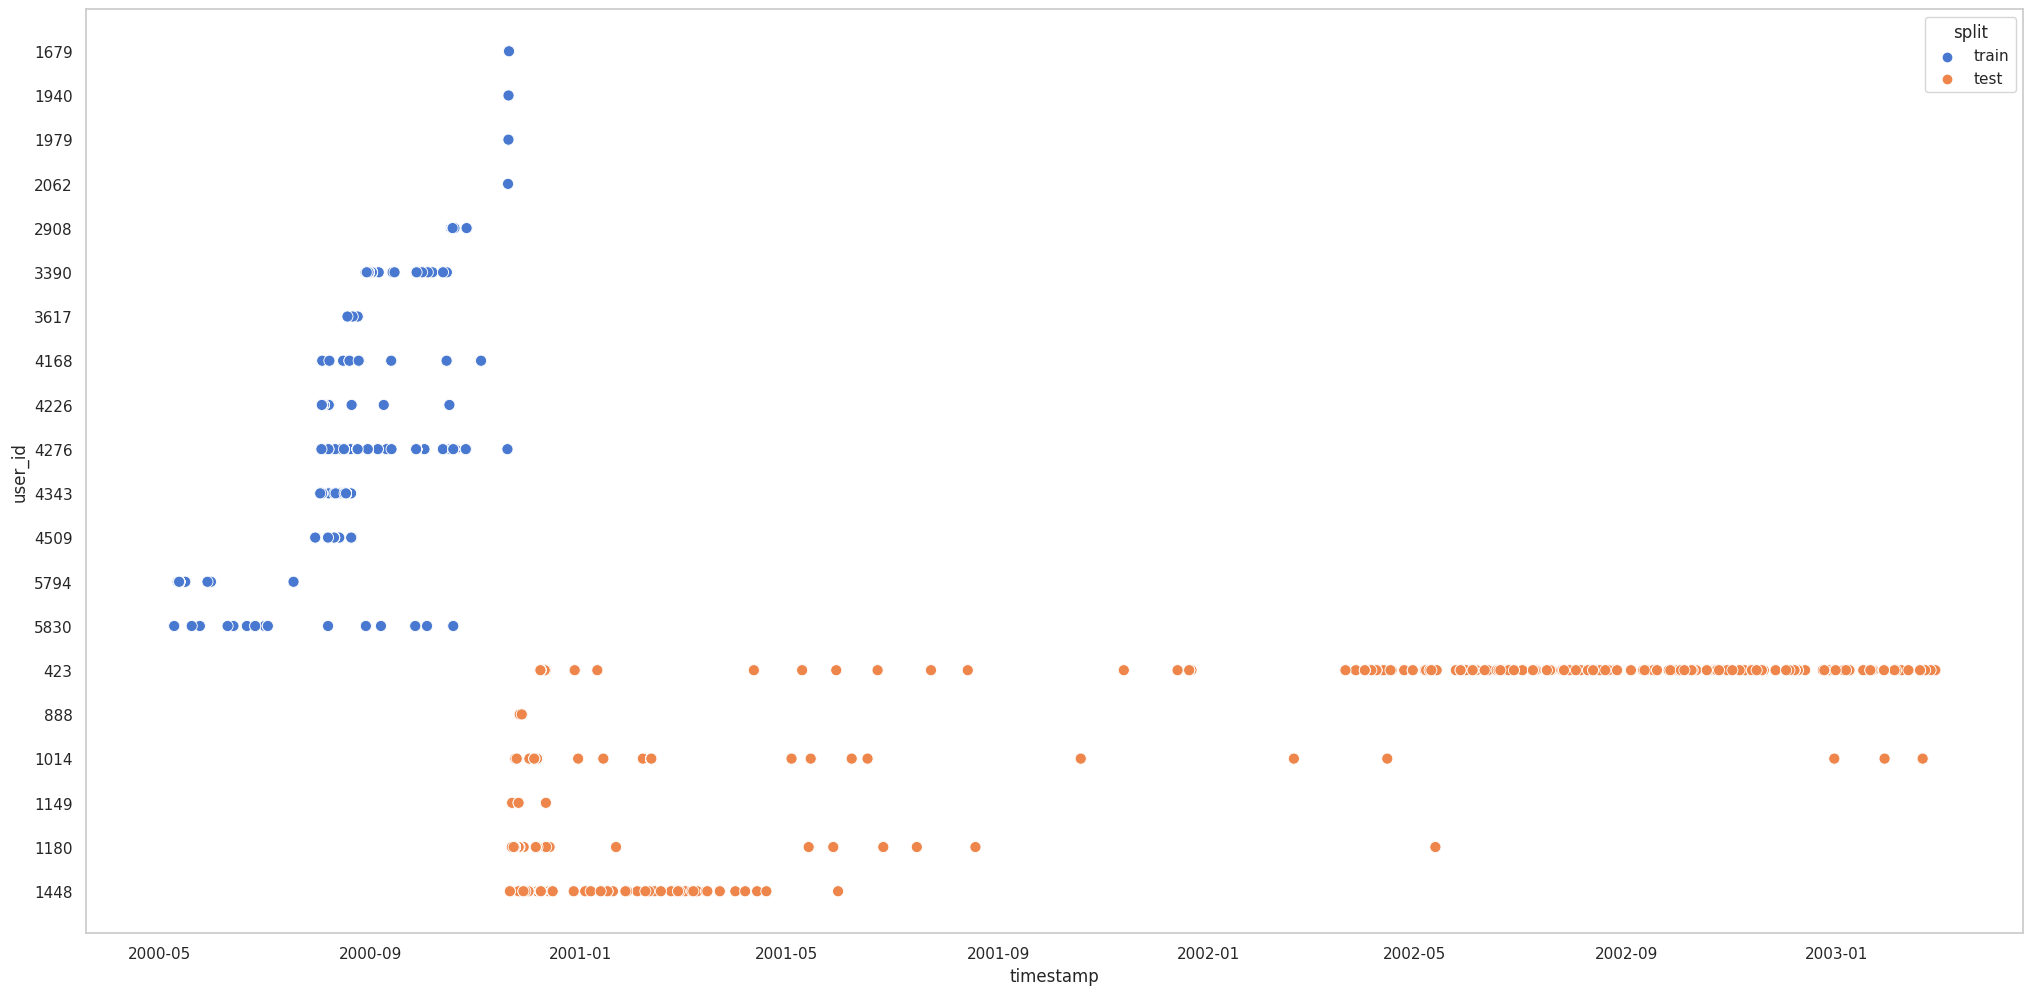

In [34]:
show_train_test(train, test)

In [35]:
get_df_info(train)

Total rows 13952, unique users: 14, unique items: 2931


In [36]:
get_df_info(test)

Total rows 8096, unique users: 6, unique items: 2757


## class ColdUserRandomSplitter()

Test set consists of all actions of randomly chosen users.

#### Parameters other than general

* `test_size` float 

* `seed` random seed

In [37]:
from replay.splitters import ColdUserRandomSplitter

cold_user_random_splitter = ColdUserRandomSplitter(
    test_size=0.3,
    query_column="user_id",
)

In [38]:
train, test = cold_user_random_splitter.split(log_limit_20)

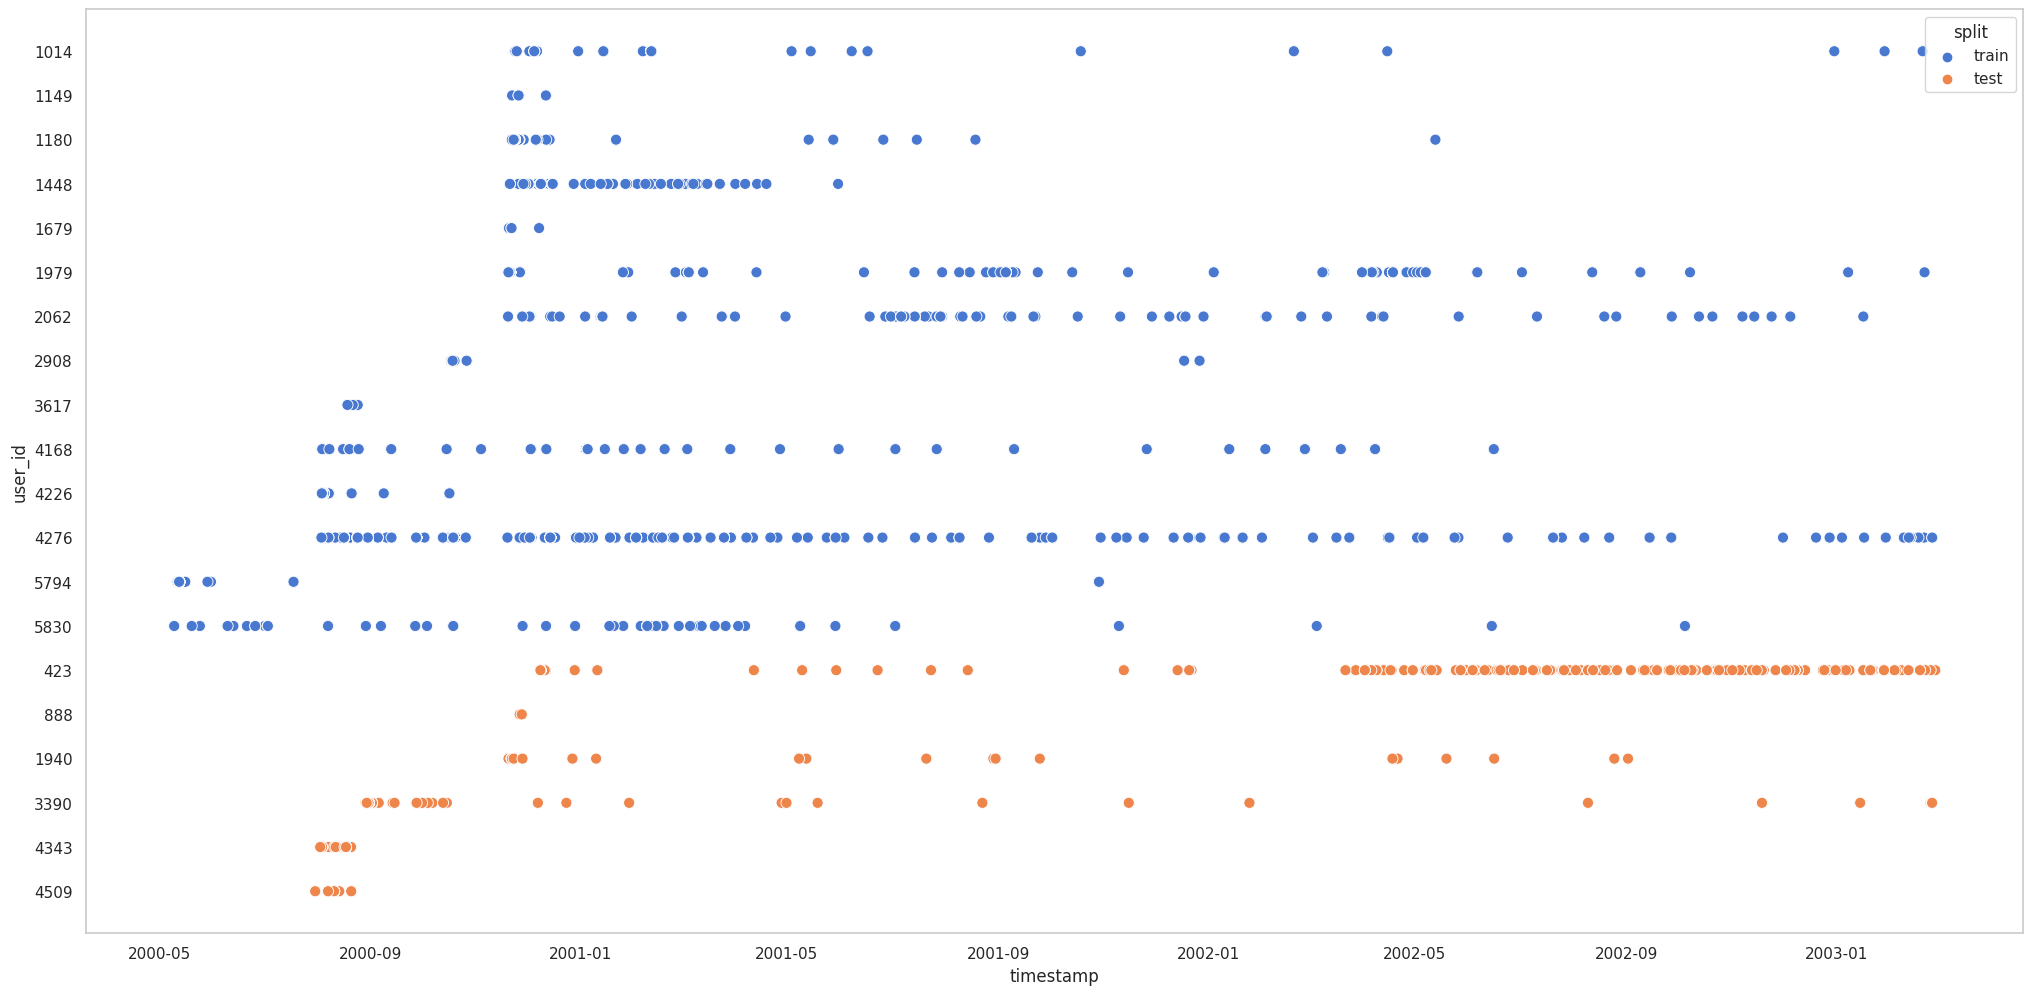

In [39]:
show_train_test(train, test)

In [40]:
get_df_info(train)

Total rows 20163, unique users: 14, unique items: 3263


In [41]:
get_df_info(test)

Total rows 8066, unique users: 6, unique items: 2755


## class TwoStageSplitter()

Split data by two columns.

#### Parameters other than general

* `item_test_size` Number of items to be added to the test for each user

* `user_test_size` Number of users to be added to the test

* `seed` random seed

In this example 10 users are randomly selected, 50 products are included in the test for each user. `shuffle` parameter is False. Separation in each selected user occurs on a timeline

In [42]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=10,
    second_divide_size=50,
    shuffle=False,
    query_column="user_id",
    first_divide_column="user_id",
)

In [43]:
train, test = user_splitter.split(log_limit_20)

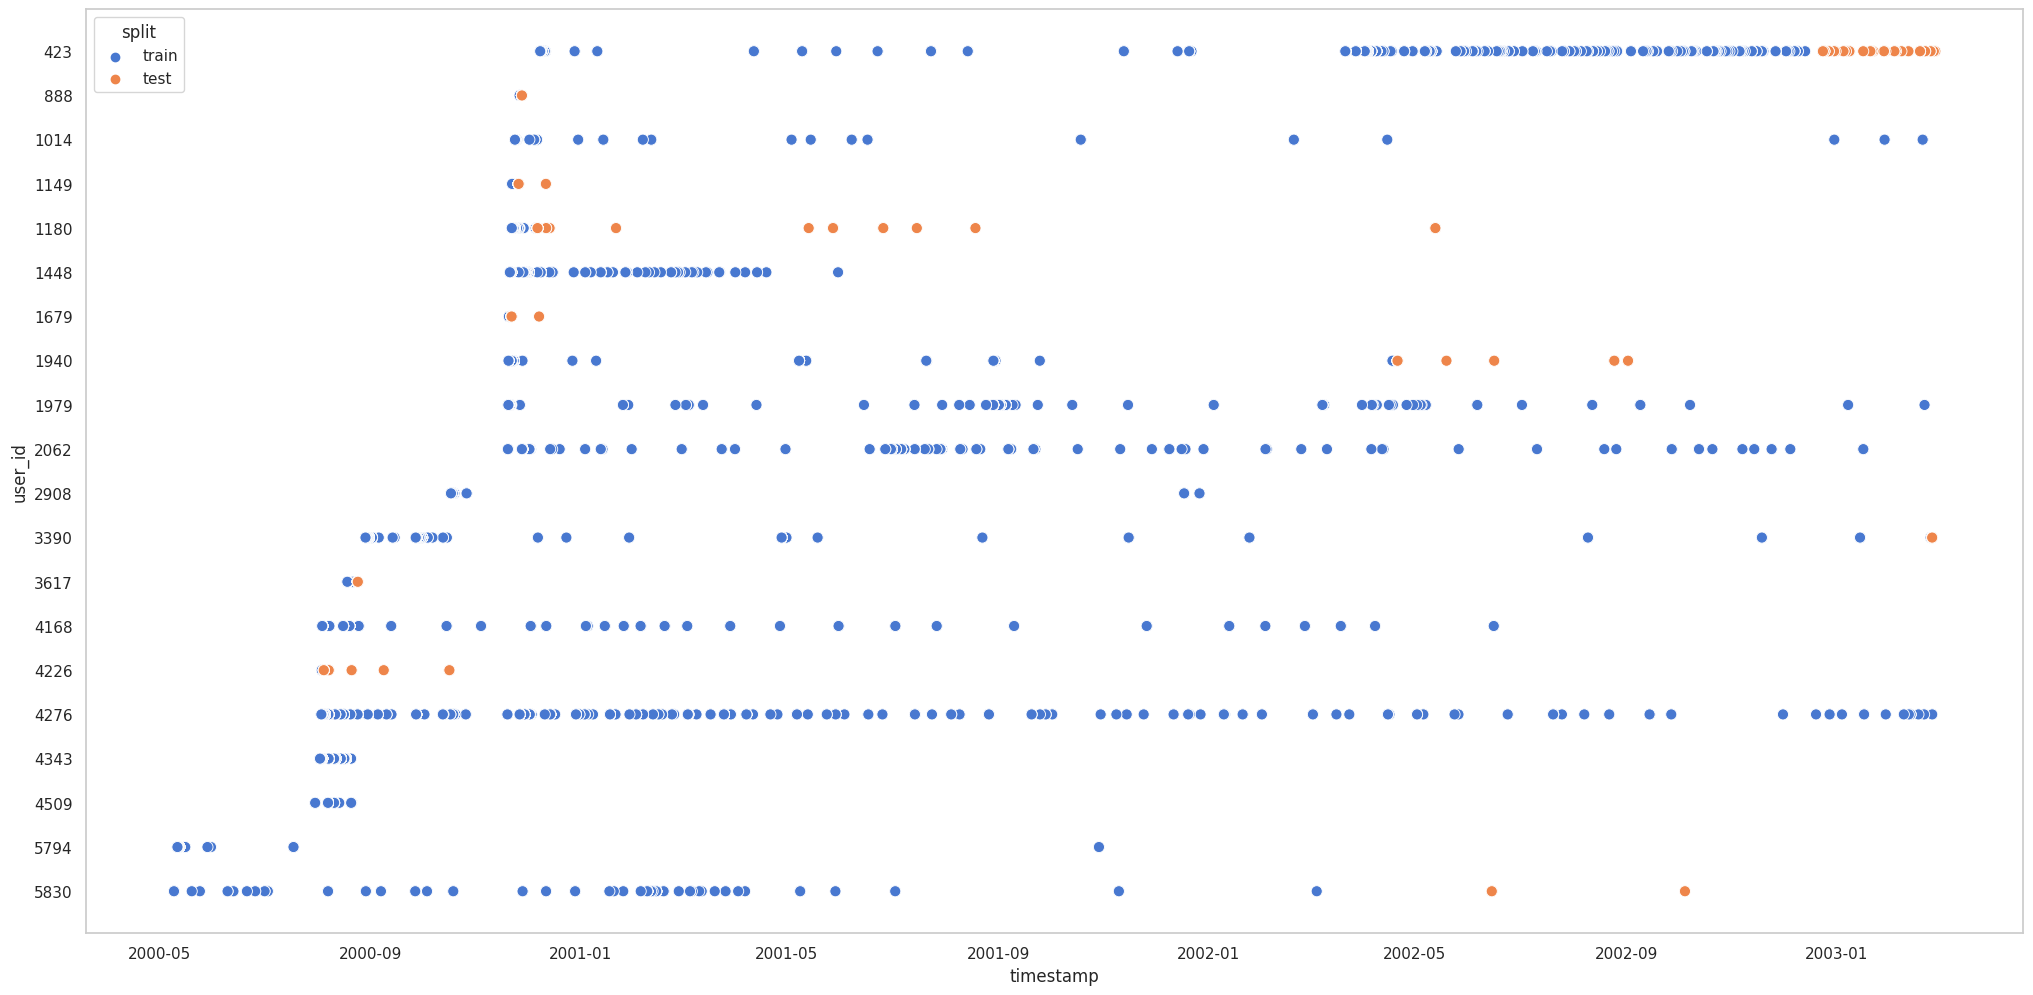

In [44]:
show_train_test(train, test)

In [45]:
get_df_info(train)

Total rows 27729, unique users: 20, unique items: 3320


In [46]:
get_df_info(test)

Total rows 500, unique users: 10, unique items: 459


In this example 10 users are randomly selected, 50 products are included in the test for each user. In this example `shuffle` parameter is True. Split in each selected user occurs random

In [47]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=10,
    second_divide_size=50,
    shuffle=True,
    query_column="user_id",
    first_divide_column="user_id",
)

In [48]:
train, test = user_splitter.split(log_limit_20)

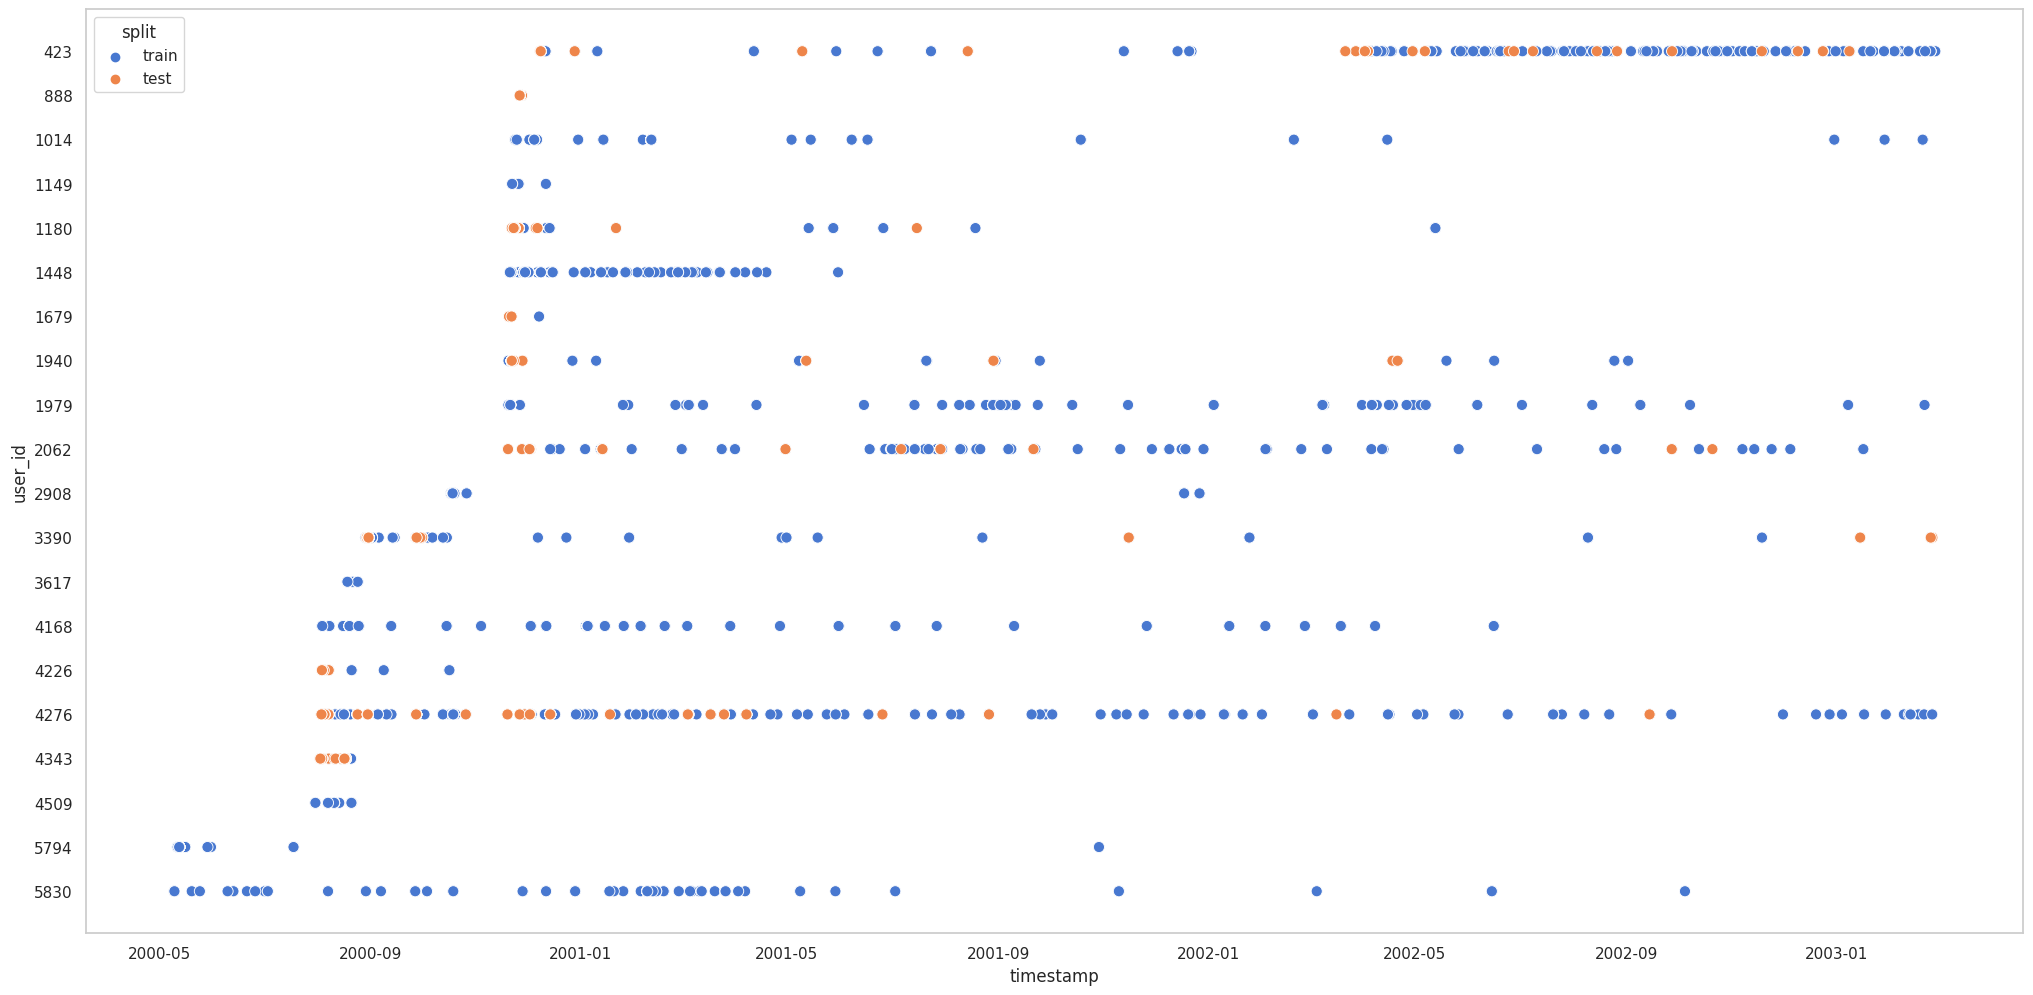

In [49]:
show_train_test(train, test)

In [50]:
get_df_info(train)

Total rows 27729, unique users: 20, unique items: 3322


In [51]:
get_df_info(test)

Total rows 500, unique users: 10, unique items: 466


You can use **float** as input for `item_test_size` or `user_test_size` parameters

In [52]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=0.5,
    second_divide_size=0.015,
    shuffle=True,
    query_column="user_id",
    first_divide_column="user_id",
)

In [53]:
train, test = user_splitter.split(log_limit_20)

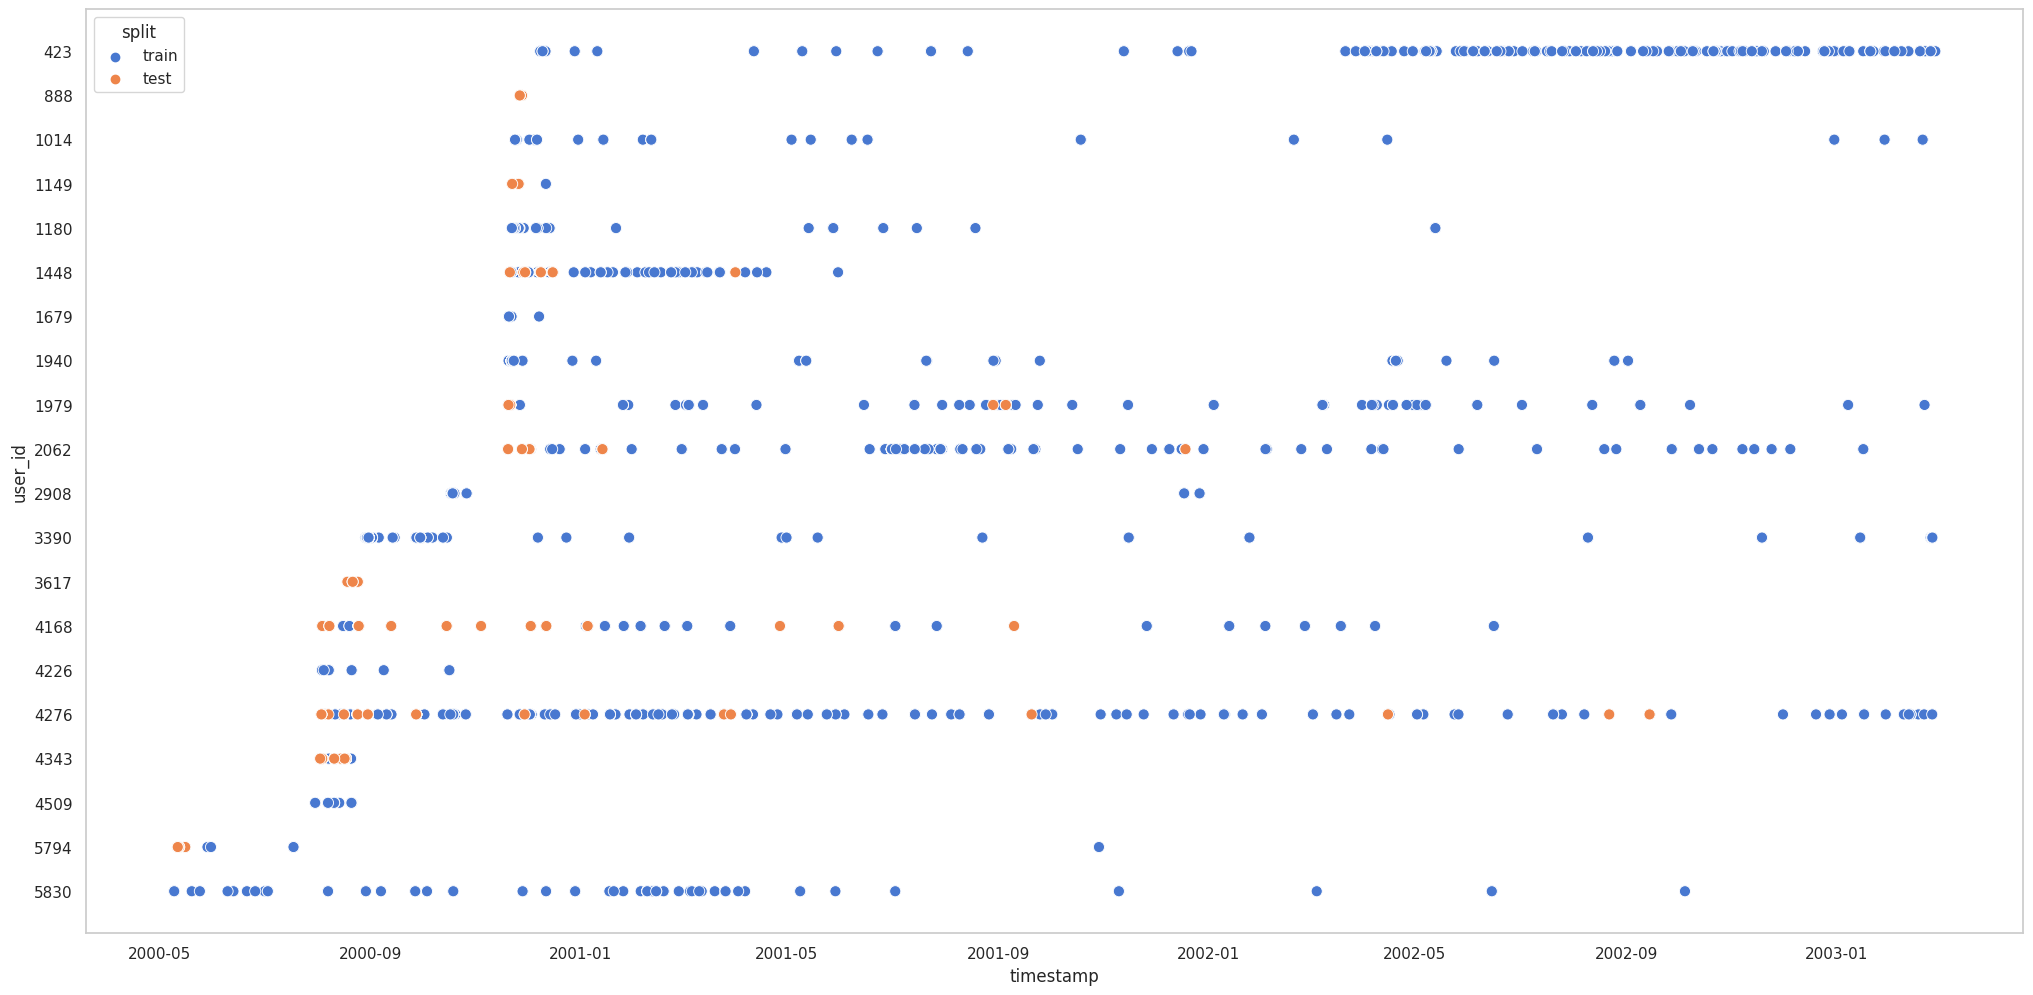

In [54]:
show_train_test(train, test)

In [55]:
get_df_info(train)

Total rows 28015, unique users: 20, unique items: 3321


In [56]:
get_df_info(test)

Total rows 214, unique users: 10, unique items: 208
